# Considerações iniciais:

Nesta etapa iniciaremos a aplicação das técnicas de modelagem para resolução do problema. A técnica escolhida foi:

* Método de Holt Winter's para Séries Temporais (leva em conta tendências e sazonalidades)

O motivo de escolha da técnica é o simples fato de se tratar de um modelagem que envolve fatores temporais. Criamos nossa variável resposta em dependência do tempo e assumiremos daí suas projeções.

Para métrica de avaliação dos modelos usaremos o R² Score.

## Carregamentos dos pacotes & Definição de funções

In [653]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

from datetime import date, timedelta
from pylab import rcParams

# Métrica de avaliação - R² Score
from sklearn.metrics import r2_score

# Método de Holt Winter's
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ExpSmooth

## Carregamento das tabelas de modelagem e criação dos respectivos Data Frames

In [3]:
df01 = pd.read_csv("sla_abt_clie01.csv")
df02 = pd.read_csv("sla_abt_clie02.csv")
df03 = pd.read_csv("sla_abt_clie03.csv")
df04 = pd.read_csv("sla_abt_clie04.csv")
df05 = pd.read_csv("sla_abt_clie05.csv")
df06 = pd.read_csv("sla_abt_clie06.csv")
df07 = pd.read_csv("sla_abt_clie07.csv")
df08 = pd.read_csv("sla_abt_clie08.csv")
df10 = pd.read_csv("sla_abt_clie10.csv")

df01.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-02,75.418994
1,2019-01-03,79.761905
2,2019-01-04,80.555556
3,2019-01-05,80.651341
4,2019-01-06,80.492424


## Visualização gráfica dos dados para análise de tendências e sazonalidade, e posterior projeção utlizando o método de Holt-Winter's

### Cliente 01 - ID: 215

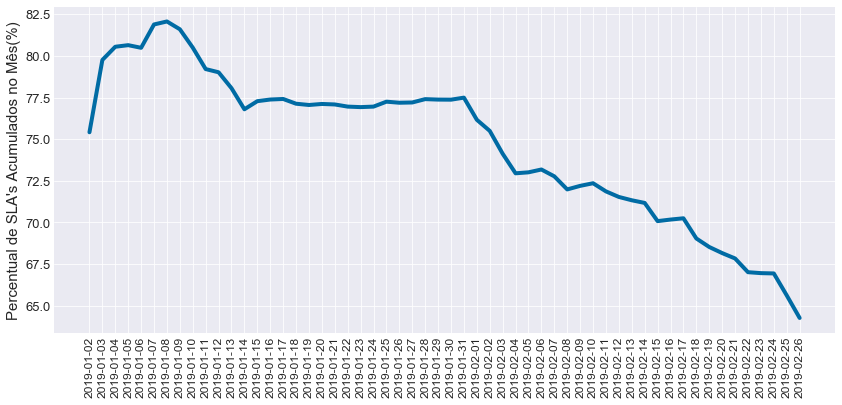

In [180]:
# Criação do gráfico
df01_x, df01_y = df01["DT_DATREF_INFO"], df01["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df01_x, df01_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

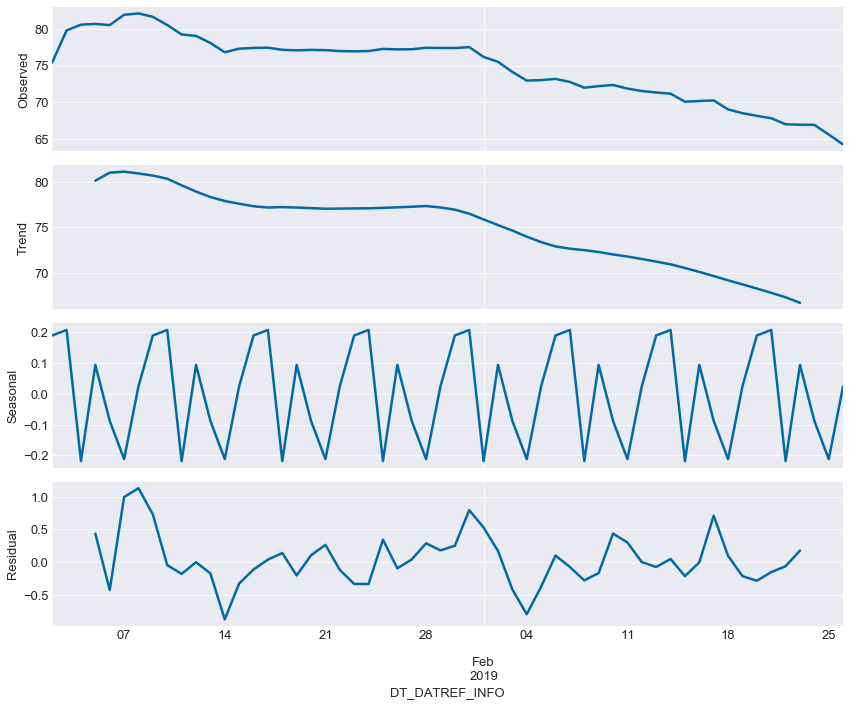

In [348]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)

serie = df01.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [828]:
# Vamos fazer uma projeção de validação divindo a amostra em 80% para treino e 20% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo
treino, teste = df01.iloc[:int(len(df01)*0.8) + 1], df01.iloc[int(len(df01)*0.8) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (45, 2), (11, 2))

In [829]:
treino.tail()

,DT_DATREF_INFO,PERC_SLAS_CUM
40,2019-02-11,71.868439
41,2019-02-12,71.534196
42,2019-02-13,71.334792
43,2019-02-14,71.174729
44,2019-02-15,70.082501


In [830]:
teste.tail()

,DT_DATREF_INFO,PERC_SLAS_CUM
51,2019-02-22,67.015131
52,2019-02-23,66.958664
53,2019-02-24,66.939891
54,2019-02-25,65.622632
55,2019-02-26,64.265130


In [831]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [832]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: 0.854
• Holt-Winter's ('add', 'add') x 3 -- R² Score: 0.553
• Holt-Winter's ('add', 'add') x 4 -- R² Score: 0.744
• Holt-Winter's ('add', 'add') x 5 -- R² Score: 0.644
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -0.655
• Holt-Winter's ('add', 'add') x 7 -- R² Score: 0.267
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -0.367
• Holt-Winter's ('add', 'add') x 9 -- R² Score: 0.38
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -2.154
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -3.315
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -0.223
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: 0.855
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: 0.559
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: 0.791
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: 0.39
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -0.232
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: 0.224
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -0.268
• Holt-Winter's ('ad

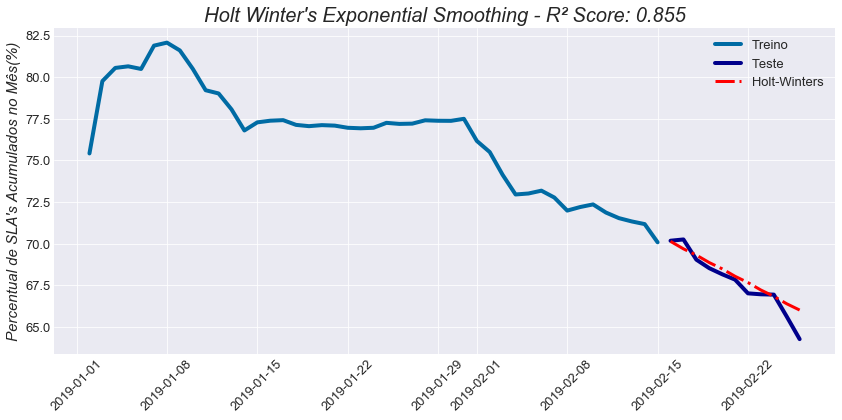

In [833]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "add", seasonal = "mul", seasonal_periods = 2).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [834]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df01 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE01"])
hw_df01

,PRED_SLA_CLIE01
2019-02-27,65.564684
2019-02-28,65.186923


### Cliente 02 - ID: 2581

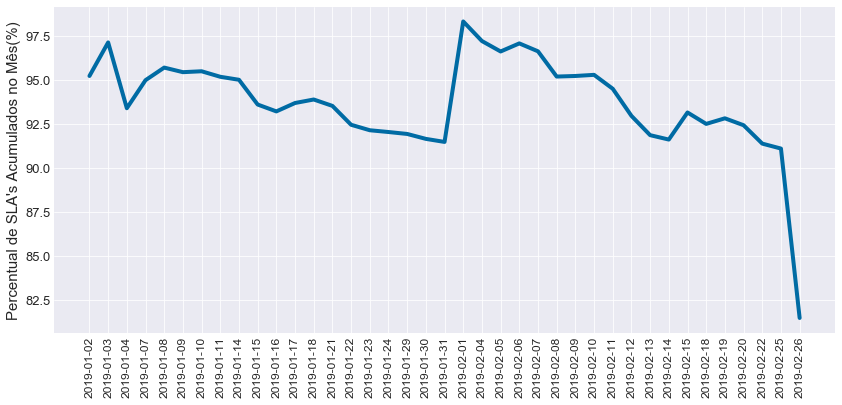

In [655]:
# Criação do gráfico
df02_x, df02_y = df02["DT_DATREF_INFO"], df02["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df02_x, df02_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

#### Obs: Este data frame em particular tem saltos no indexador temporal, ou seja não é contínuo, vamos incorporar as datas faltantes com valores oriundos de um polinômio interpolador em t

In [681]:
# Criando o novo índice de datas
datas = [date(2019, 1, 2) + timedelta(days = d) for d in range(56)]
datas = pd.Series(datas)
datas[:5]

0    2019-01-02
1    2019-01-03
2    2019-01-04
3    2019-01-05
4    2019-01-06
dtype: object

In [682]:
# Criando uma cópia do data frame 
df = df02.copy()
df["DT_DATREF_INFO"] = pd.to_datetime(df["DT_DATREF_INFO"])
df.set_index("DT_DATREF_INFO", drop = True, inplace = True)
df.tail()

,PERC_SLAS_CUM
DT_DATREF_INFO,
2019-02-19,92.834891
2019-02-20,92.441860
2019-02-22,91.397849
2019-02-25,91.116751
2019-02-26,81.497797


In [683]:
# Vamos montar um novo data frame atribuindo NaN para as datas que não possuem registros
valores = []

for data in datas:
    check = False
    for n in range(df.shape[0]):
        if df.index[n] == pd.to_datetime(data):
            check = True
            valores.append(df.values[n][0])
            break
    if check == False:
        valores.append(np.nan)
        
valores = pd.Series(valores)
datas = pd.DataFrame(datas, columns = ["DT_DATREF_INFO"])
valores = pd.DataFrame(valores, columns = ["PERC_SLAS_CUM"])
df02_ = pd.merge(datas, valores, left_index = True, right_index = True)
df02_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-02,95.238095
1,2019-01-03,97.142857
2,2019-01-04,93.406593
3,2019-01-05,NaN
4,2019-01-06,NaN


In [685]:
# Aplicaremos a função interpoladora em t
interpol_values = [x for x in df02_["PERC_SLAS_CUM"]]
interpol_index = [pd.to_datetime(x) for x in df02_["DT_DATREF_INFO"]]
interpol_serie = pd.Series(interpol_values, index = interpol_index)
interpol_serie.interpolate(method = "time", inplace = True)

valores_interpol = pd.DataFrame(interpol_serie.values, columns = ["PERC_SLAS_CUM"])
datas_interpol = pd.DataFrame(interpol_serie.index, columns = ["DT_DATREF_INFO"])
df02_ = pd.merge(datas_interpol, valores_interpol, left_index = True, right_index = True)
df02_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-02,95.238095
1,2019-01-03,97.142857
2,2019-01-04,93.406593
3,2019-01-05,93.937729
4,2019-01-06,94.468864


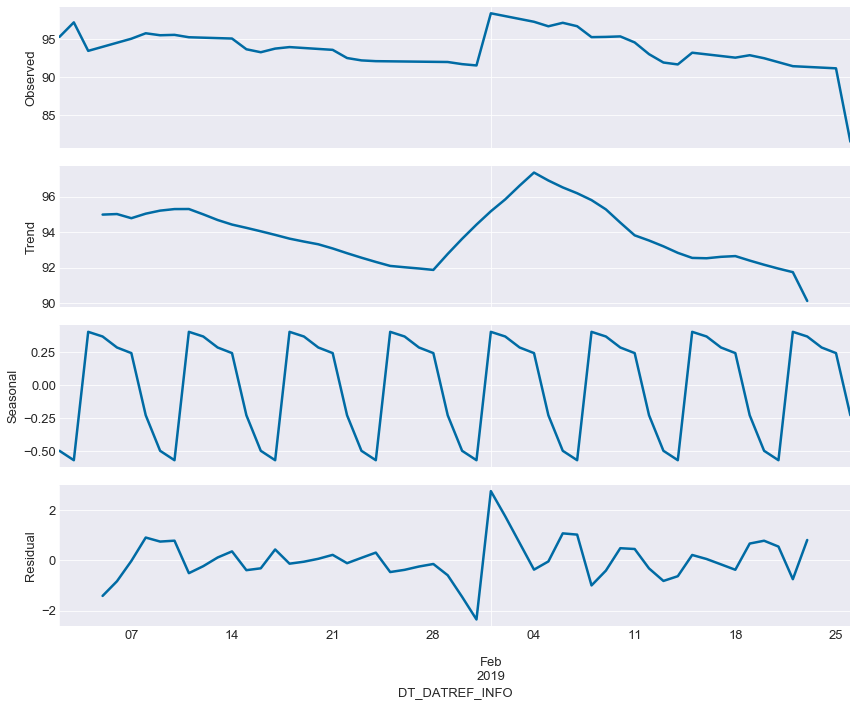

In [680]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)
serie = df02_.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [836]:
# Vamos fazer uma projeção de teste divindo a amostra em 90% para treino e 10% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo
treino, teste = df02_.iloc[:int(len(df02_)*0.9) + 1], df02_.iloc[int(len(df02_)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (51, 2), (5, 2))

In [837]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [826]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -0.451
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -0.557
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -0.503
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -0.371
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -0.255
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -0.863
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -0.574
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -0.742
• Holt-Winter's ('add', 'add') x 10 -- R² Score: 0.016
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -0.586
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -0.615
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -0.454
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -0.555
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -0.506
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -0.352
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -0.233
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -0.87
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -0.75
• Holt-Win

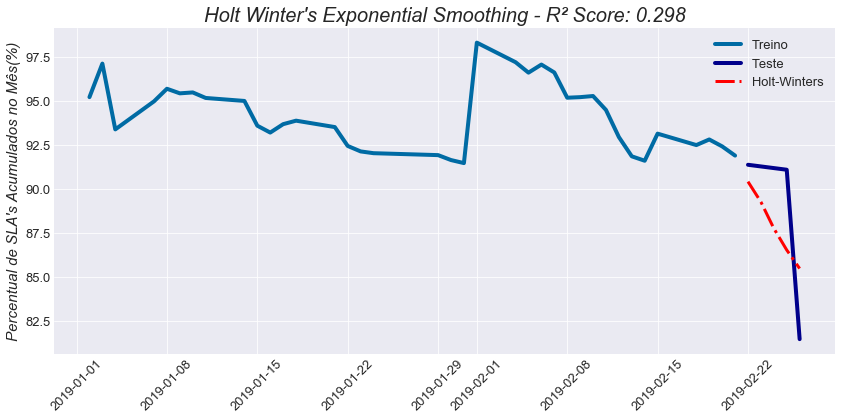

In [838]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "mul",seasonal = "add", seasonal_periods = 11).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [839]:

# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df02 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE02"])
hw_df02

,PRED_SLA_CLIE02
2019-02-27,86.271869
2019-02-28,81.411029


### Cliente 03 - ID: 8068

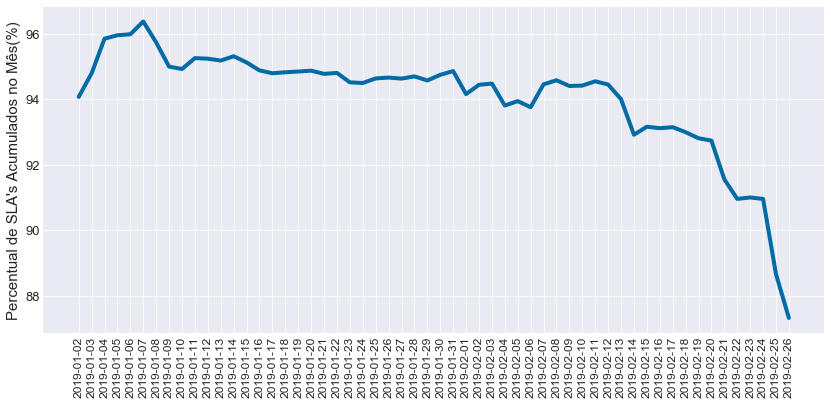

In [520]:
# Criação do gráfico
df03_x, df03_y = df03["DT_DATREF_INFO"], df03["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df03_x, df03_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

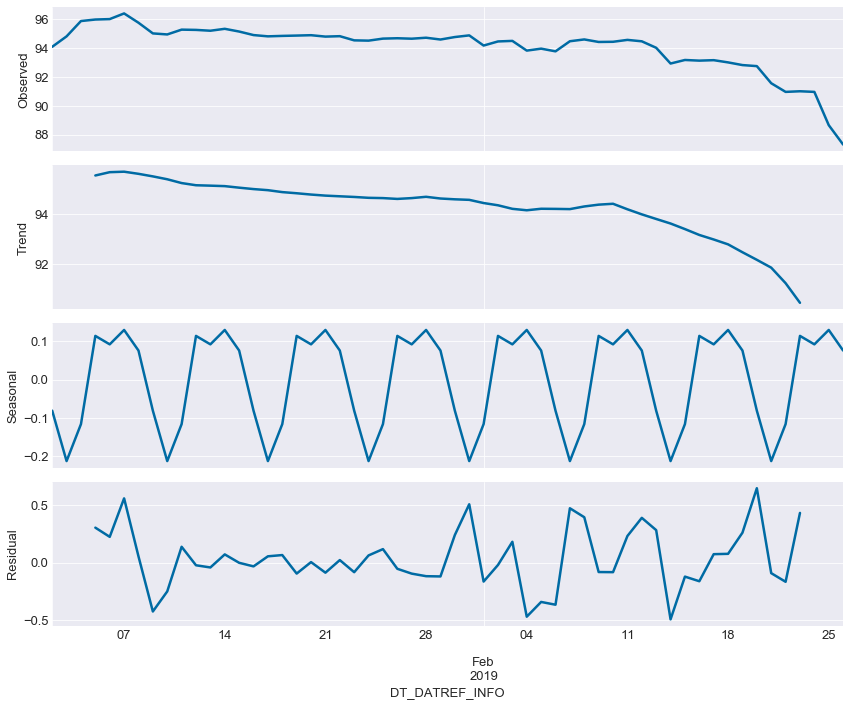

In [580]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)

serie = df03.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [534]:
# Vamos fazer uma projeção de validação divindo a amostra em 90% para treino e 10% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df03.iloc[:int(len(df03)*0.9) + 1], df03.iloc[int(len(df03)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (51, 2), (5, 2))

In [535]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [536]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -0.696
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -0.925
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -0.133
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -0.906
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -1.396
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -3.026
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -1.972
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -1.556
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -0.888
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -1.012
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -2.056
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: 0.686
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -0.734
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -0.539
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: 0.216
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -0.042
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -1.419
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -1.973
• Holt-Wi

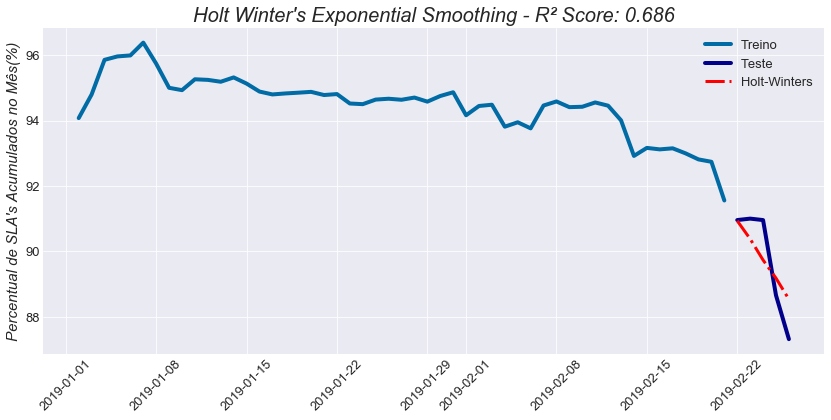

In [537]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "add",seasonal = "mul", seasonal_periods = 2).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [538]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df03 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE03"])
hw_df03

,PRED_SLA_CLIE03
2019-02-27,87.981691
2019-02-28,87.337097


### Cliente 04 - ID: 39159

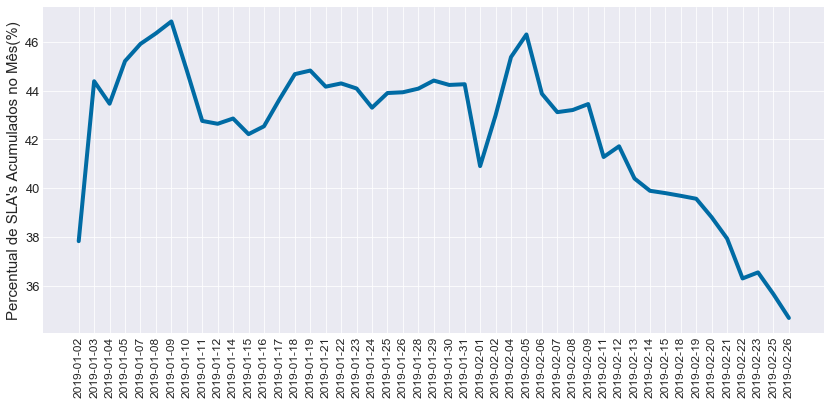

In [539]:
# Criação do gráfico
df04_x, df04_y = df04["DT_DATREF_INFO"], df04["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df04_x, df04_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

#### Obs: Este data frame em particular tem saltos no indexador temporal, ou seja não é contínuo, vamos incorporar as datas faltantes com valores oriundos de um polinômio interpolador em t

In [743]:
# Criando o novo índice de datas
datas = [date(2019, 1, 2) + timedelta(days = d) for d in range(56)]
datas = pd.Series(datas)

# Criando uma cópia do data frame 
df = df04.copy()
df["DT_DATREF_INFO"] = pd.to_datetime(df["DT_DATREF_INFO"])
df.set_index("DT_DATREF_INFO", drop = True, inplace = True)

# Vamos montar um novo data frame atribuindo NaN para as datas que não possuem registros
valores = []

for data in datas:
    check = False
    for n in range(df.shape[0]):
        if df.index[n] == pd.to_datetime(data):
            check = True
            valores.append(df.values[n][0])
            break
    if check == False:
        valores.append(np.nan)
        
valores = pd.Series(valores)
datas = pd.DataFrame(datas, columns = ["DT_DATREF_INFO"])
valores = pd.DataFrame(valores, columns = ["PERC_SLAS_CUM"])
df04_ = pd.merge(datas, valores, left_index = True, right_index = True)
df04_.tail()

,DT_DATREF_INFO,PERC_SLAS_CUM
51,2019-02-22,36.312849
52,2019-02-23,36.559735
53,2019-02-24,NaN
54,2019-02-25,35.668157
55,2019-02-26,34.694836


In [745]:
# Aplicaremos a função interpoladora em t
interpol_values = [x for x in df04_["PERC_SLAS_CUM"]]
interpol_index = [pd.to_datetime(x) for x in df04_["DT_DATREF_INFO"]]
interpol_serie = pd.Series(interpol_values, index = interpol_index)
interpol_serie.interpolate(method = "time", inplace = True)

valores_interpol = pd.DataFrame(interpol_serie.values, columns = ["PERC_SLAS_CUM"])
datas_interpol = pd.DataFrame(interpol_serie.index, columns = ["DT_DATREF_INFO"])
df04_ = pd.merge(datas_interpol, valores_interpol, left_index = True, right_index = True)
df04_.tail()

,DT_DATREF_INFO,PERC_SLAS_CUM
51,2019-02-22,36.312849
52,2019-02-23,36.559735
53,2019-02-24,36.113946
54,2019-02-25,35.668157
55,2019-02-26,34.694836


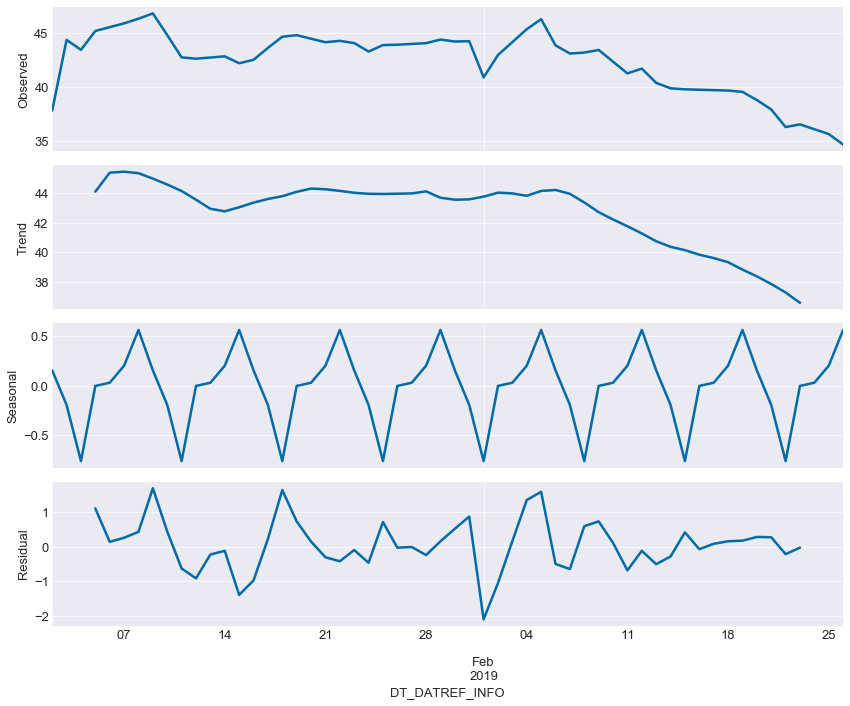

In [746]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)
serie = df04_.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [760]:
# Vamos fazer uma projeção de teste divindo a amostra em 70% para treino e 30% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df04_.iloc[:int(len(df04_)*0.7) + 1], df04_.iloc[int(len(df04_)*0.7) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (40, 2), (16, 2))

In [761]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [762]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -1.429
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -3.159
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -1.546
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -0.122
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -4.975
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -6.965
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -6.783
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -6.998
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -6.446
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -6.207
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -5.485
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -1.101
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -6.495
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -3.375
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -2.493
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -6.518
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -6.924
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -6.583
• Holt-

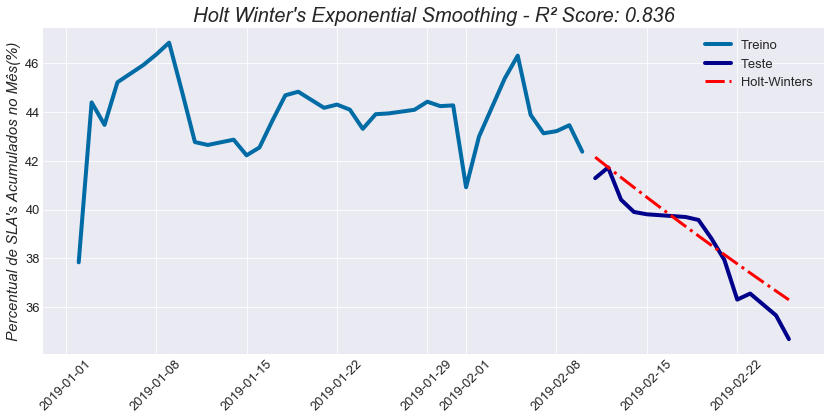

In [763]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "mul",seasonal = None, seasonal_periods = 3).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [764]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df04 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE04"])
hw_df04

,PRED_SLA_CLIE04
2019-02-27,35.944125
2019-02-28,35.588533


### Cliente 05 - ID: 87520

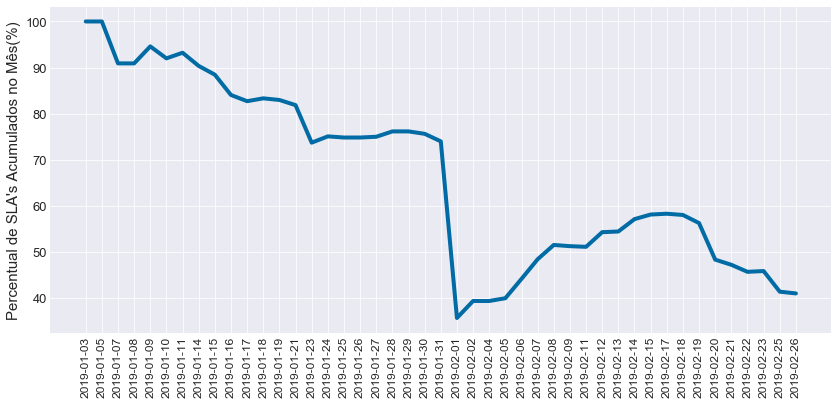

In [562]:
# Criação do gráfico
df05_x, df05_y = df05["DT_DATREF_INFO"], df05["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df05_x, df05_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

#### Obs: Este data frame em particular tem saltos no indexador temporal, ou seja não é contínuo, vamos incorporar as datas faltantes com valores oriundos de um polinômio interpolador em t

In [840]:
# Criando o novo índice de datas
datas = [date(2019, 1, 3) + timedelta(days = d) for d in range(55)]
datas = pd.Series(datas)

# Criando uma cópia do data frame 
df = df05.copy()
df["DT_DATREF_INFO"] = pd.to_datetime(df["DT_DATREF_INFO"])
df.set_index("DT_DATREF_INFO", drop = True, inplace = True)

# Montando o novo data frame com o range de datas atualizado e os valores faltantes preenchidos
valores = []

# Vamos montar um novo data frame atribuindo NaN para as datas que não possuem registros
valores = []

for data in datas:
    check = False
    for n in range(df.shape[0]):
        if df.index[n] == pd.to_datetime(data):
            check = True
            valores.append(df.values[n][0])
            break
    if check == False:
        valores.append(np.nan)
        
valores = pd.Series(valores)
datas = pd.DataFrame(datas, columns = ["DT_DATREF_INFO"])
valores = pd.DataFrame(valores, columns = ["PERC_SLAS_CUM"])
df05_ = pd.merge(datas, valores, left_index = True, right_index = True)
df05_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-03,100.000000
1,2019-01-04,NaN
2,2019-01-05,100.000000
3,2019-01-06,NaN
4,2019-01-07,90.909091


In [841]:
# Aplicaremos a função interpoladora em t
interpol_values = [x for x in df05_["PERC_SLAS_CUM"]]
interpol_index = [pd.to_datetime(x) for x in df05_["DT_DATREF_INFO"]]
interpol_serie = pd.Series(interpol_values, index = interpol_index)
interpol_serie.interpolate(method = "time", inplace = True)

valores_interpol = pd.DataFrame(interpol_serie.values, columns = ["PERC_SLAS_CUM"])
datas_interpol = pd.DataFrame(interpol_serie.index, columns = ["DT_DATREF_INFO"])
df05_ = pd.merge(datas_interpol, valores_interpol, left_index = True, right_index = True)
df05_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-03,100.000000
1,2019-01-04,100.000000
2,2019-01-05,100.000000
3,2019-01-06,95.454545
4,2019-01-07,90.909091


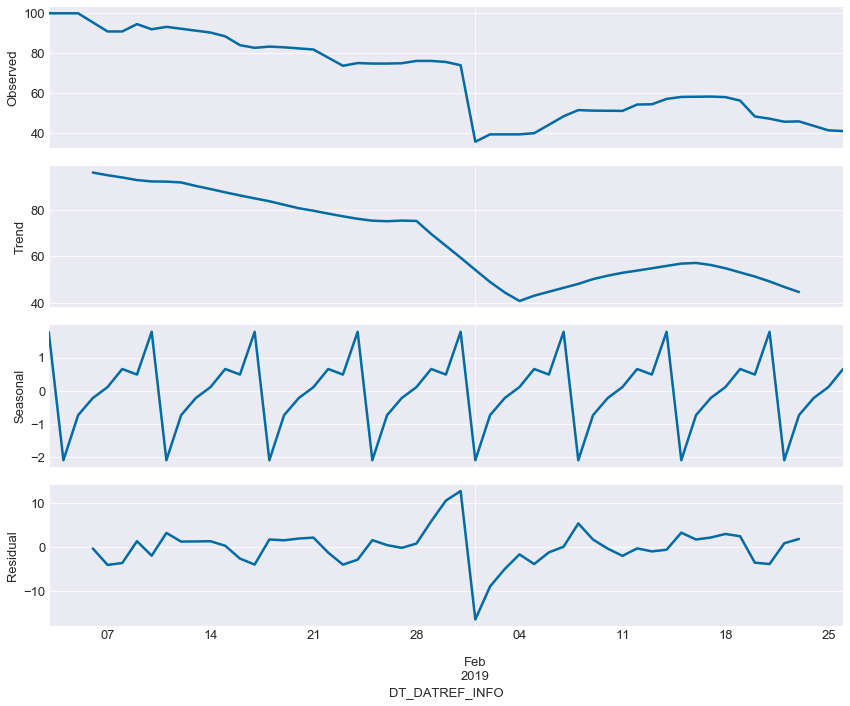

In [842]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)
serie = df05_.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [846]:
# Vamos fazer uma projeção de teste divindo a amostra em 80% para treino e 20% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df05_.iloc[:int(len(df05_)*0.8) + 1], df05_.iloc[int(len(df05_)*0.8) + 1:]

serie.shape, treino.shape, teste.shape

((55, 1), (45, 2), (10, 2))

In [847]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [848]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -1.854
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -1.153
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -1.971
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -4.773
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -0.087
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -0.21
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -1.939
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -1.92
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -4.957
• Holt-Winter's ('add', 'add') x 11 -- R² Score: 0.742
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -2.656
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -0.803
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -2.761
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -1.958
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -2.643
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -0.573
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -0.403
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -1.249
• Holt-Win

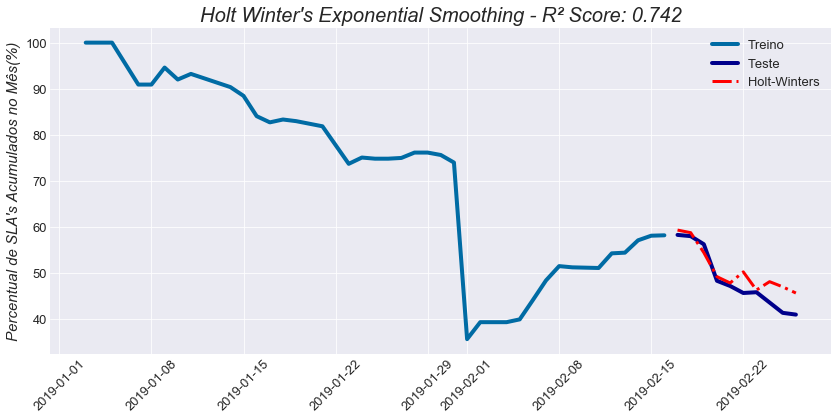

In [849]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "add",seasonal = "add", seasonal_periods = 11).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [850]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df05 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE05"])
hw_df05

,PRED_SLA_CLIE05
2019-02-27,52.222715
2019-02-28,53.001626


### Cliente 06 - ID: 372301

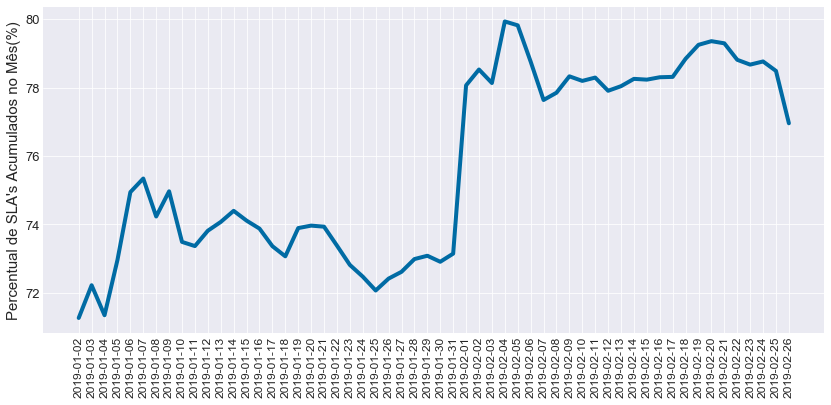

In [851]:
# Criação do gráfico
df06_x, df06_y = df06["DT_DATREF_INFO"], df06["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df06_x, df06_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

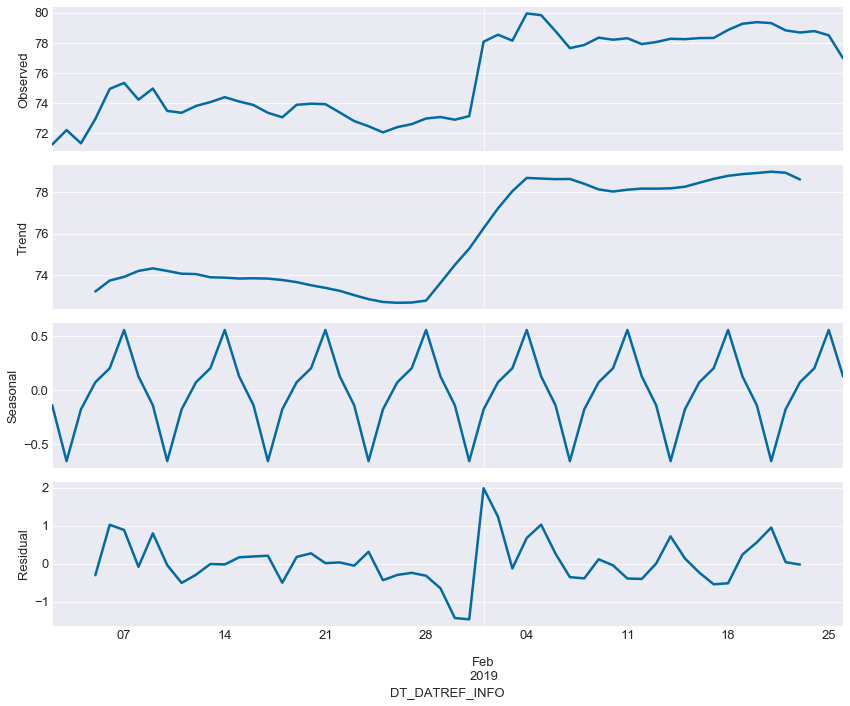

In [852]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)

serie = df06.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [856]:
# Vamos fazer uma projeção de validação divindo a amostra em 90% para treino e 10% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df06.iloc[:int(len(df06)*0.9) + 1], df06.iloc[int(len(df06)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (51, 2), (5, 2))

In [857]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [858]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -4.774
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -5.677
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -3.175
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -5.497
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -6.085
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -11.044
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -4.055
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -2.433
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -3.616
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -3.686
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -35.436
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -4.733
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -5.84
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -4.614
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -5.303
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -6.011
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -12.716
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -3.366
• Hol

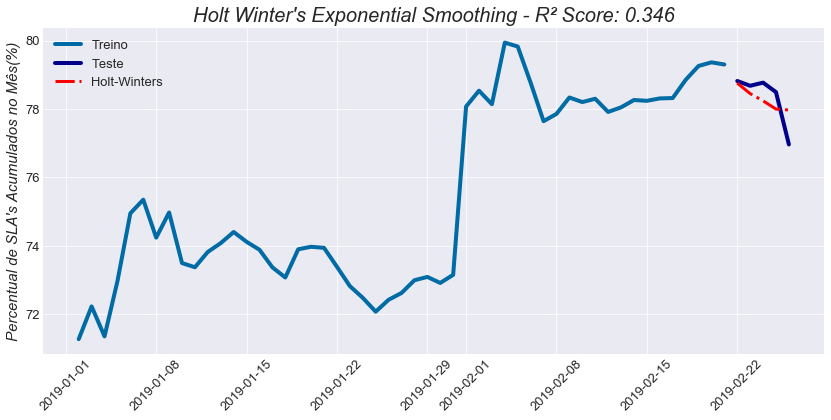

In [596]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "mul",seasonal = "mul", seasonal_periods = 5).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [597]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df06 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE06"])
hw_df06

,PRED_SLA_CLIE06
2019-02-27,77.405248
2019-02-28,77.102864


### Cliente 07 - ID: 797391

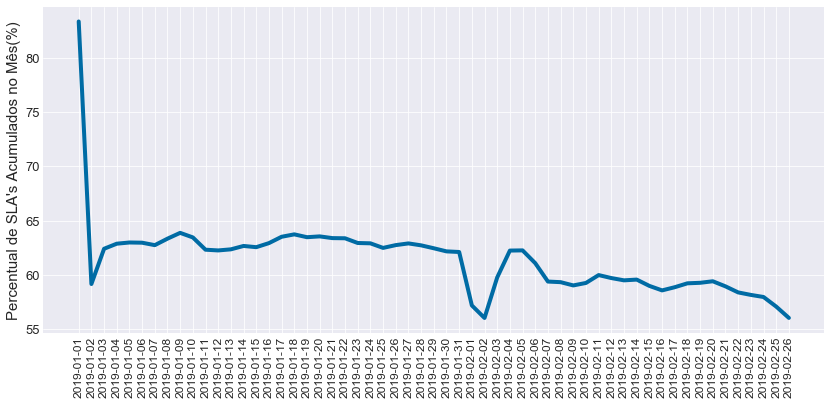

In [598]:
# Criação do gráfico
df07_x, df07_y = df07["DT_DATREF_INFO"], df07["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df07_x, df07_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

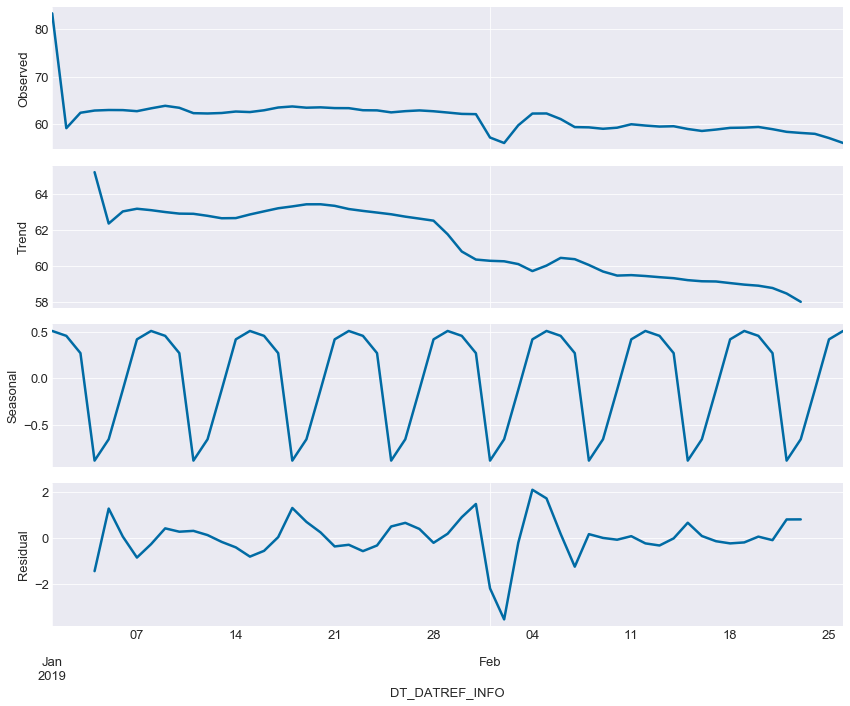

In [599]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)

serie = df07.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [607]:
# Vamos fazer uma projeção de validação divindo a amostra em 70% para treino e 30% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df07.iloc[:int(len(df07)*0.9) + 1], df07.iloc[int(len(df07)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((57, 1), (52, 2), (5, 2))

In [609]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [610]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -3.277
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -2.804
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -2.252
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -1.233
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -2.104
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -1.907
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -1.543
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -1.002
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -1.089
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -1.281
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -0.782
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -3.493
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -2.735
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -2.314
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -1.3
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -2.174
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -2.034
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -1.67
• Holt-Win

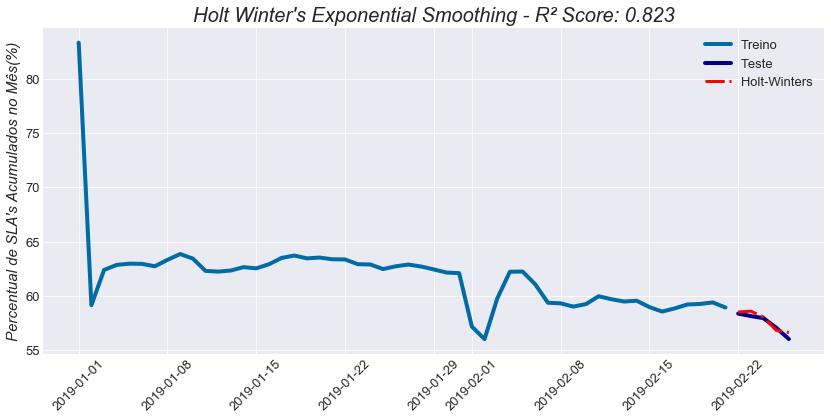

In [611]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "mul",seasonal = "add", seasonal_periods = 12).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [612]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df07 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE07"])
hw_df07

,PRED_SLA_CLIE07
2019-02-27,57.060736
2019-02-28,56.739779


### Cliente 08 - ID: 900102

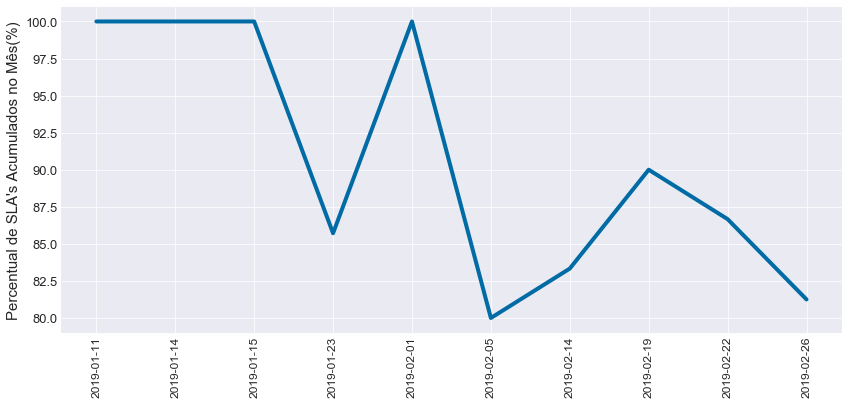

In [614]:
# Criação do gráfico
df08_x, df08_y = df08["DT_DATREF_INFO"], df08["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df08_x, df08_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

#### Obs: Este data frame em particular tem saltos no indexador temporal, ou seja não é contínuo, vamos incorporar as datas faltantes com valores oriundos de um polinômio interpolador em t

In [859]:
# Criando o novo índice de datas
datas = [date(2019, 1, 11) + timedelta(days = d) for d in range(47)]
datas = pd.Series(datas)

# Criando uma cópia do data frame 
df = df08.copy()
df["DT_DATREF_INFO"] = pd.to_datetime(df["DT_DATREF_INFO"])
df.set_index("DT_DATREF_INFO", drop = True, inplace = True)

# Vamos montar um novo data frame atribuindo NaN para as datas que não possuem registros
valores = []

for data in datas:
    check = False
    for n in range(df.shape[0]):
        if df.index[n] == pd.to_datetime(data):
            check = True
            valores.append(df.values[n][0])
            break
    if check == False:
        valores.append(np.nan)
        
valores = pd.Series(valores)
datas = pd.DataFrame(datas, columns = ["DT_DATREF_INFO"])
valores = pd.DataFrame(valores, columns = ["PERC_SLAS_CUM"])
df08_ = pd.merge(datas, valores, left_index = True, right_index = True)
df08_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-11,100.0
1,2019-01-12,NaN
2,2019-01-13,NaN
3,2019-01-14,100.0
4,2019-01-15,100.0


In [860]:
# Aplicaremos a função interpoladora em t
interpol_values = [x for x in df08_["PERC_SLAS_CUM"]]
interpol_index = [pd.to_datetime(x) for x in df08_["DT_DATREF_INFO"]]
interpol_serie = pd.Series(interpol_values, index = interpol_index)
interpol_serie.interpolate(method = "time", inplace = True)

valores_interpol = pd.DataFrame(interpol_serie.values, columns = ["PERC_SLAS_CUM"])
datas_interpol = pd.DataFrame(interpol_serie.index, columns = ["DT_DATREF_INFO"])
df08_ = pd.merge(datas_interpol, valores_interpol, left_index = True, right_index = True)
df08_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-11,100.0
1,2019-01-12,100.0
2,2019-01-13,100.0
3,2019-01-14,100.0
4,2019-01-15,100.0


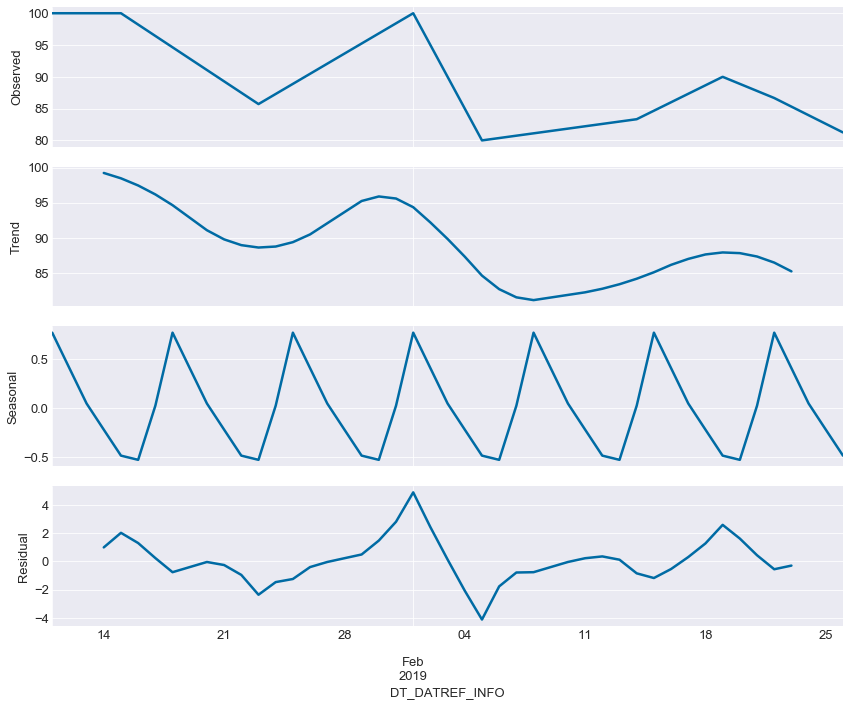

In [861]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)
serie = df08_.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [862]:
# Vamos fazer uma projeção de teste divindo a amostra em 90% para treino e 10% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df08_.iloc[:int(len(df08_)*0.9) + 1], df08_.iloc[int(len(df08_)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((47, 1), (43, 2), (4, 2))

In [863]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [864]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: 0.648
• Holt-Winter's ('add', 'add') x 3 -- R² Score: 0.807
• Holt-Winter's ('add', 'add') x 4 -- R² Score: 0.807
• Holt-Winter's ('add', 'add') x 5 -- R² Score: 0.807
• Holt-Winter's ('add', 'add') x 6 -- R² Score: -1.789
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -1.846
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -1.871
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -8.176
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -46.874
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -41.084
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -0.74
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: 0.626
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: 0.985
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: 0.627
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -0.406
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: -2.608
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -0.307
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -12.008
• Holt-Winte

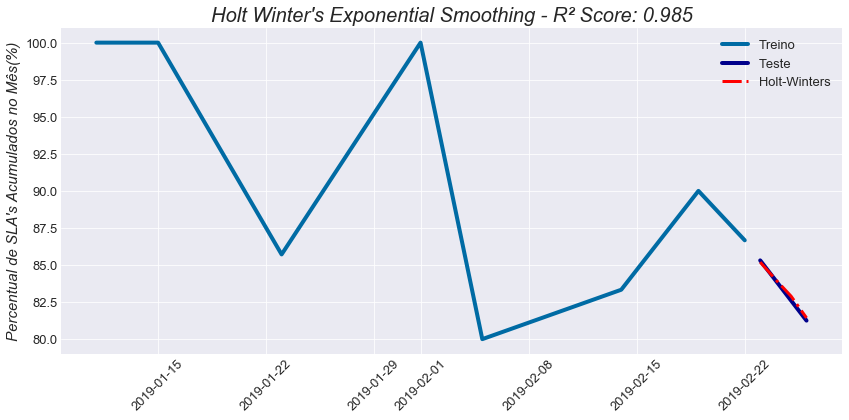

In [865]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "add",seasonal = "mul", seasonal_periods = 3).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [866]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df08 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE08"])
hw_df08

,PRED_SLA_CLIE08
2019-02-27,80.251845
2019-02-28,79.128278


### Cliente 10 - ID: 900995

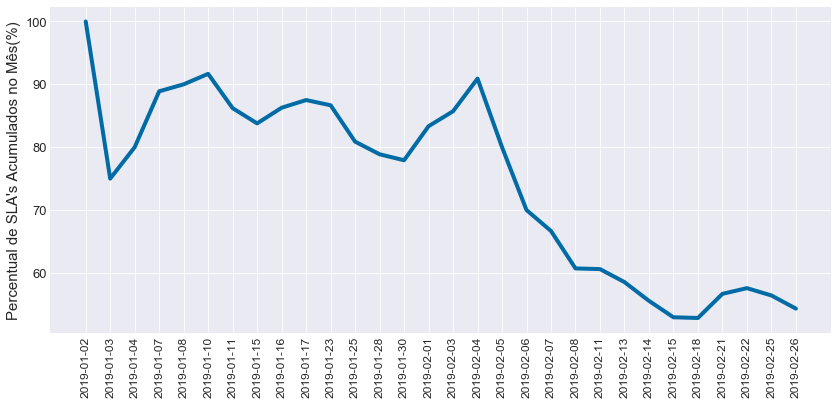

In [630]:
# Criação do gráfico
df10_x, df10_y = df10["DT_DATREF_INFO"], df10["PERC_SLAS_CUM"]

plt.style.use("seaborn-darkgrid")
plt.figure(figsize = (14,6))
plt.plot(df10_x, df10_y, lw = 4)
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.show()

#### Este data frame em particular tem saltos no indexador temporal, ou seja não é contínuo, vamos incorporar as datas faltantes com valores oriundos de um polinômio interpolador em t

In [867]:
# Criando o novo índice de datas
datas = [date(2019, 1, 2) + timedelta(days = d) for d in range(56)]
datas = pd.Series(datas)

# Criando uma cópia do data frame 
df = df10.copy()
df["DT_DATREF_INFO"] = pd.to_datetime(df["DT_DATREF_INFO"])
df.set_index("DT_DATREF_INFO", drop = True, inplace = True)

# Vamos montar um novo data frame atribuindo NaN para as datas que não possuem registros
valores = []

for data in datas:
    check = False
    for n in range(df.shape[0]):
        if df.index[n] == pd.to_datetime(data):
            check = True
            valores.append(df.values[n][0])
            break
    if check == False:
        valores.append(np.nan)
        
valores = pd.Series(valores)
datas = pd.DataFrame(datas, columns = ["DT_DATREF_INFO"])
valores = pd.DataFrame(valores, columns = ["PERC_SLAS_CUM"])
df10_ = pd.merge(datas, valores, left_index = True, right_index = True)
df10_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-02,100.0
1,2019-01-03,75.0
2,2019-01-04,80.0
3,2019-01-05,NaN
4,2019-01-06,NaN


In [868]:
# Aplicaremos a função interpoladora em t
interpol_values = [x for x in df10_["PERC_SLAS_CUM"]]
interpol_index = [pd.to_datetime(x) for x in df10_["DT_DATREF_INFO"]]
interpol_serie = pd.Series(interpol_values, index = interpol_index)
interpol_serie.interpolate(method = "time", inplace = True)

valores_interpol = pd.DataFrame(interpol_serie.values, columns = ["PERC_SLAS_CUM"])
datas_interpol = pd.DataFrame(interpol_serie.index, columns = ["DT_DATREF_INFO"])
df10_ = pd.merge(datas_interpol, valores_interpol, left_index = True, right_index = True)
df10_.head()

,DT_DATREF_INFO,PERC_SLAS_CUM
0,2019-01-02,100.000000
1,2019-01-03,75.000000
2,2019-01-04,80.000000
3,2019-01-05,82.962963
4,2019-01-06,85.925926


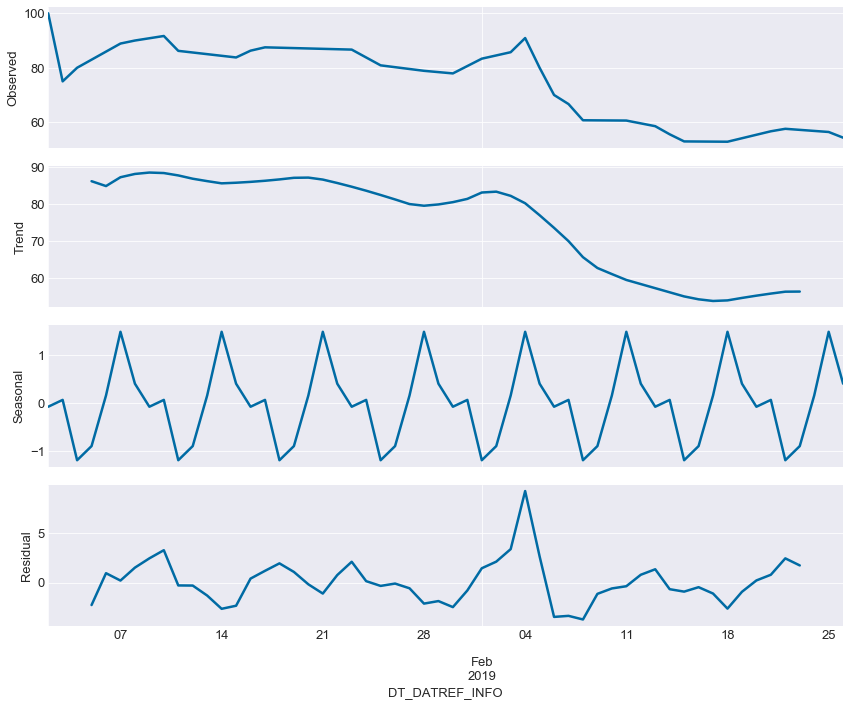

In [869]:
# Decomposição da série em Tendência, Sazonalidade e Resíduo(componente aleatório)
serie = df10_.copy()
serie["DT_DATREF_INFO"] = pd.to_datetime(serie["DT_DATREF_INFO"])
serie.set_index("DT_DATREF_INFO", drop = True, inplace = True)

rcParams["figure.figsize"]= 12, 10
rcParams["font.size"] = 13
rcParams["lines.linewidth"] = 2.5

decomposition = sm.tsa.seasonal_decompose(serie)
decomposition.plot()
plt.show()

In [876]:
# Vamos fazer uma projeção de teste divindo a amostra em 90% para treino e 10% para teste
# Estes valores vieram de vários testes perfomando os passos abaixo

treino, teste = df10_.iloc[:int(len(df10_)*0.9) + 1], df10_.iloc[int(len(df10_)*0.9) + 1:]

serie.shape, treino.shape, teste.shape

((56, 1), (51, 2), (5, 2))

In [877]:
treino_val = [x for x in treino["PERC_SLAS_CUM"]]
treino_index = [pd.to_datetime(x) for x in treino["DT_DATREF_INFO"]]
s_treino = pd.Series(treino_val, treino_index)

teste_val = [x for x in teste["PERC_SLAS_CUM"]]
teste_index = [pd.to_datetime(x) for x in teste["DT_DATREF_INFO"]]
s_teste = pd.Series(teste_val, teste_index)

### Holt Winter's Exponential Smoothing

In [878]:
# Vamos realizar um "grid search" para tentar encontrar os parâmetros de tendência, sazonalidade e períodos de sazonalidade
# que se ajustam melhor aos dados. Vamos usar como métrica o R² Score, onde o modelo com o maior valor é o vencedor.

t = s = ["add", "mul", None]
ts = list(itertools.product(t, s))

for param in ts:
    for season_period in range(13):
        try:
            holt_winters      = ExpSmooth(s_treino, trend = param[0],seasonal = param[1], seasonal_periods = season_period).fit()
            holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])
            r2score           = round(r2_score(s_teste, holt_winters_pred), 3)
            print("• Holt-Winter's {} x {} -- R² Score: {}".format(param, season_period, r2score))
        except:
            continue

• Holt-Winter's ('add', 'add') x 2 -- R² Score: -5.528
• Holt-Winter's ('add', 'add') x 3 -- R² Score: -3.418
• Holt-Winter's ('add', 'add') x 4 -- R² Score: -5.122
• Holt-Winter's ('add', 'add') x 5 -- R² Score: -2.835
• Holt-Winter's ('add', 'add') x 6 -- R² Score: 0.272
• Holt-Winter's ('add', 'add') x 7 -- R² Score: -0.722
• Holt-Winter's ('add', 'add') x 8 -- R² Score: -77.683
• Holt-Winter's ('add', 'add') x 9 -- R² Score: -2.761
• Holt-Winter's ('add', 'add') x 10 -- R² Score: -64.487
• Holt-Winter's ('add', 'add') x 11 -- R² Score: -3.736
• Holt-Winter's ('add', 'add') x 12 -- R² Score: -1.694
• Holt-Winter's ('add', 'mul') x 2 -- R² Score: -2.387
• Holt-Winter's ('add', 'mul') x 3 -- R² Score: -3.918
• Holt-Winter's ('add', 'mul') x 4 -- R² Score: -5.752
• Holt-Winter's ('add', 'mul') x 5 -- R² Score: -3.454
• Holt-Winter's ('add', 'mul') x 6 -- R² Score: 0.552
• Holt-Winter's ('add', 'mul') x 7 -- R² Score: -1.642
• Holt-Winter's ('add', 'mul') x 8 -- R² Score: -49.603
• Holt

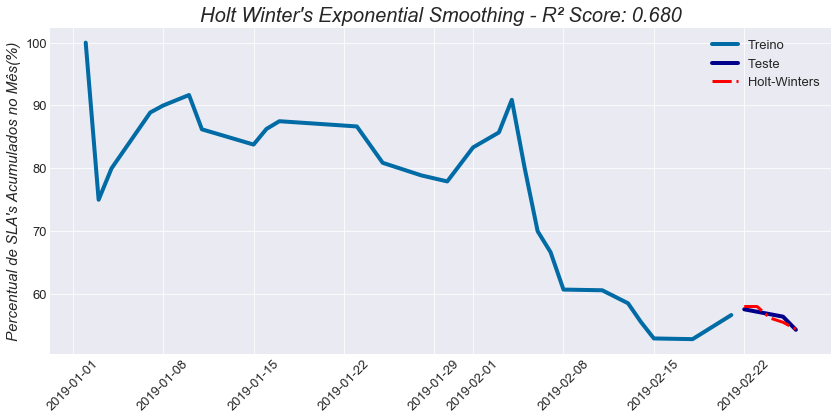

In [879]:
# Fitting do modelo
holt_winters = ExpSmooth(s_treino, trend = "mul",seasonal = "add", seasonal_periods = 6).fit()

# Predição
holt_winters_pred = holt_winters.predict(start = s_teste.index[0], end = s_teste.index[-1])

#Avaliação do modelo
r2score = round(r2_score(s_teste, holt_winters_pred), 3)

# Visualização Gráfica
plt.figure(figsize = (14,6))
plt.plot(s_treino.index, s_treino, label="Treino", lw = 4)
plt.plot(s_teste.index, s_teste, label="Teste", lw = 4, color = "darkblue")
plt.plot(holt_winters_pred.index, holt_winters_pred, label="Holt-Winters", lw = 3, linestyle = "-.", color = "red")
plt.xticks(rotation = 45)
plt.title("Holt Winter's Exponential Smoothing - R² Score: %.3f" % r2score, fontsize = 20, style = "italic")
plt.ylabel("Percentual de SLA's Acumulados no Mês(%)", fontsize = 15, style = "oblique")
plt.legend(loc="best")
plt.show()

In [880]:
# Vamos prever o restante dos pontos

holt_winters_pred = holt_winters.predict(start = s_teste.index[-1], end = s_teste.index[-1] + timedelta(days = 2))
hw = holt_winters_pred[s_teste.index[-1] + timedelta(days = 1):]

hw_df10 = pd.DataFrame(hw.values, index = hw.index, columns = ["PRED_SLA_CLIE10"])
hw_df10

,PRED_SLA_CLIE10
2019-02-27,52.804296
2019-02-28,55.643658


## Vamos finalizar criando o data frame final contendo todos os clientes e os valores projetados

In [889]:
# Merge de todos os data frames com os resultados de cada cliente
df_m01 = pd.merge(hw_df01, hw_df02, left_index = True, right_index = True)
df_m02 = pd.merge(hw_df03, hw_df04, left_index = True, right_index = True)
df_m03 = pd.merge(hw_df05, hw_df06, left_index = True, right_index = True)
df_m04 = pd.merge(hw_df07, hw_df08, left_index = True, right_index = True)
aux = pd.merge(df_m01, df_m02, left_index = True, right_index = True)
aux = pd.merge(aux, df_m03, left_index = True, right_index = True)
aux = pd.merge(aux, df_m04, left_index = True, right_index = True)
df_final = pd.merge(aux, hw_df10, left_index = True, right_index = True)

In [890]:
#Visualização da tabela final
df_final

,PRED_SLA_CLIE01,PRED_SLA_CLIE02,PRED_SLA_CLIE03,PRED_SLA_CLIE04,PRED_SLA_CLIE05,PRED_SLA_CLIE06,PRED_SLA_CLIE07,PRED_SLA_CLIE08,PRED_SLA_CLIE10
2019-02-27,65.564684,86.271869,87.981691,35.944125,52.222715,77.405248,57.060736,80.251845,52.804296
2019-02-28,65.186923,81.411029,87.337097,35.588533,53.001626,77.102864,56.739779,79.128278,55.643658
